In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [3]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

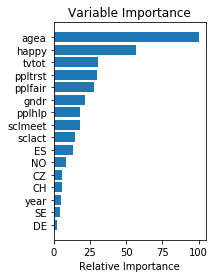

In [4]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

### Feature Engineering

First, a correlation matrix wil be run to see how the features correlate to one another and if any features can be combined. 

In [5]:
df.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,1.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,1.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,2.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,1.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,1.0


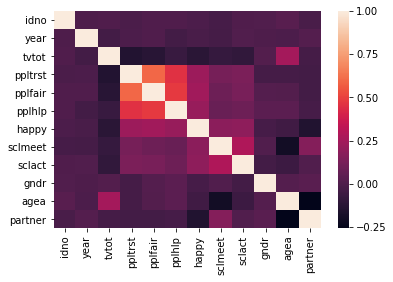

In [6]:
import seaborn as sns
# create a correlation matrix
corr=df.corr()

# plot the correlation matrix
sns.heatmap(corr)

The features 'ppltrst' pplfair' and 'pplhlp' seem to have some correlation, and in the real world seem similar. For these reasons, the 3 features will be combined into one feature. 

In [7]:
# combine ppltrst, pplfair and pplhlp into one feature 
means = df[['ppltrst','pplfair','pplhlp']].mean(axis=0)
stds = df[['ppltrst','pplfair','pplhlp']].std(axis=0)
df['trust_fair_help'] = ((df[['ppltrst','pplfair','pplhlp']] - means) / stds).mean(axis=1)

### Re-Test

In [8]:
# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
Z = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'ppltrst', 'pplhlp', 'pplfair'])]

# Make the categorical variable 'country' into dummies.
Z = pd.concat([Z, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(Z.shape[0] * 0.9)

# Put 90% of the data in the training set.
Z_train, Z_train = Z[:offset], Z[:offset]

# And put 10% in the test set.
Z_test, y_test = Z[offset:], y[offset:]

# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(Z_train, y_train)

predict_train = clf.predict(Z_train)
predict_test = clf.predict(Z_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.040780141843971635
Percent Type II errors: 0.17212220403709766

Test set accuracy:
Percent Type I errors: 0.06134969325153374
Percent Type II errors: 0.18895705521472392


Even with the combined feature of 'trust_fair_help', the model does not improve much, and is more error prone against the null hypothesis in the test set. 

### More iterations

In [9]:
# We'll make 1000 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 1000,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(Z_train, y_train)

predict_train = clf.predict(Z_train)
predict_test = clf.predict(Z_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.03927986906710311
Percent Type II errors: 0.15766503000545554

Test set accuracy:
Percent Type I errors: 0.0687116564417178
Percent Type II errors: 0.19141104294478528


The errors lowered for the training set, but increased with the test set. This likely means the model is off, and we need to readjust the features or other attributes of the model

### Change the loss function

In [10]:
# We'll make 1000 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 1000,
          'max_depth': 2,
          'loss': 'exponential'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(Z_train, y_train)

predict_train = clf.predict(Z_train)
predict_test = clf.predict(Z_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.040780141843971635
Percent Type II errors: 0.1638025095471904

Test set accuracy:
Percent Type I errors: 0.0687116564417178
Percent Type II errors: 0.18650306748466258


Changing the loss function reduced Type II errors, but slightly incereased the Type I errors in both the training and test sets. However, 1000 iterations were kept in this run, showing that the model is better fit with the exponential loss function. How do the cross validation scores look?

### Cross Validation

In [11]:
# run 10-fold cross validation on gradient boost model
from sklearn.model_selection import cross_validate
cv_results = cross_validate(clf, Z, y, cv=10, return_train_score=False)
print(cv_results)

{'fit_time': array([2.37183595, 2.23698378, 2.17250705, 2.06505227, 2.09717894,
       2.14725399, 2.13024211, 2.11967516, 2.08901405, 2.11388183]), 'score_time': array([0.005651  , 0.00651121, 0.0054059 , 0.00711393, 0.0055871 ,
       0.00557399, 0.0056572 , 0.00669312, 0.00486183, 0.00477695]), 'test_score': array([0.74877451, 0.64460784, 0.70098039, 0.70429448, 0.75798526,
       0.77027027, 0.72850123, 0.73218673, 0.75184275, 0.74692875])}


In [12]:
cv_results['test_score'].mean()

0.7286372211340634

The model shows significant overfitting, how does the max depth affect the overfitting?

### Changing max depth

In [13]:
# We'll make 1000 iterations, use 4-deep trees, and set our loss function.
params = {'n_estimators': 1000,
          'max_depth': 4,
          'loss': 'exponential'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(Z_train, y_train)

predict_train = clf.predict(Z_train)
predict_test = clf.predict(Z_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.007637752318603383
Percent Type II errors: 0.06587561374795417

Test set accuracy:
Percent Type I errors: 0.09693251533742331
Percent Type II errors: 0.17177914110429449


When running the model with 4-level depth, the error scores in training set drop dramatically, while the errors in the test set decreased by 1%. How do the cross validation scores look for 4-level depth?

In [14]:
# run 10-fold cross validation on gradient boost model
from sklearn.model_selection import cross_validate
cv_results = cross_validate(clf, Z, y, cv=10, return_train_score=False)
print(cv_results)

{'fit_time': array([5.75188303, 5.5016799 , 5.572788  , 5.34447002, 5.44242096,
       5.25591111, 5.45244789, 5.66374397, 5.33139992, 5.22642779]), 'score_time': array([0.01163411, 0.00997591, 0.01055717, 0.01034617, 0.01038885,
       0.01004386, 0.01052189, 0.01073289, 0.00898004, 0.00932193]), 'test_score': array([0.74877451, 0.57107843, 0.65441176, 0.70674847, 0.74078624,
       0.76044226, 0.72358722, 0.64127764, 0.74692875, 0.73955774])}


In [15]:
cv_results['test_score'].mean()

0.7033593024719874

The cross validation score shows very little decrease in overfitting with a more in-depth model. This means the increase in error is not coming from overfitting, but from another error source. It is possible that the feature engineering process created more bias in the dataset. For example, it could be that 'ppltrst' is a good indicator of whether someone has a partner, but 'pplfair' is not. What happens when the max depth of the model is increased?  

In [16]:
# We'll make 1000 iterations, use 8-deep trees, and set our loss function.
params = {'n_estimators': 1000,
          'max_depth': 8,
          'loss': 'exponential'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(Z_train, y_train)

predict_train = clf.predict(Z_train)
predict_test = clf.predict(Z_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0

Test set accuracy:
Percent Type I errors: 0.09447852760736196
Percent Type II errors: 0.16809815950920245


Increasing the max depth to 8 levels reduced all errors in the training set to 0, and reduced the Type II errors in the test set by 1%. This improvement shows that the errors are likely coming from a lack of sub-sampling, which more levels helps to ameliorate. What is the optimum depth level for this model?     

In [24]:
# create a range of max depths to test
for md in range(2, 72, 8):
    # We'll make 1000 iterations, use 8-deep trees, and set our loss function.
    params = {'n_estimators': 1000,
              'max_depth': md,
              'loss': 'exponential'}

    # Initialize and fit the model.
    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(Z_train, y_train)
    predict_train = clf.predict(Z_train)
    predict_test = clf.predict(Z_test)

    # Accuracy tables.
    table_train = pd.crosstab(y_train, predict_train, margins=True)
    table_test = pd.crosstab(y_test, predict_test, margins=True)

    train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
    train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

    test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
    test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

    print((
        '\n\nResults for max depth of {}\n'
        'Training set accuracy:\n'
        'Percent Type I errors: {}\n'
        'Percent Type II errors: {}\n\n'
        'Test set accuracy:\n'
        'Percent Type I errors: {}\n'
        'Percent Type II errors: {}'
    ).format(md, train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))



Results for max depth of 2
Training set accuracy:
Percent Type I errors: 0.040780141843971635
Percent Type II errors: 0.1638025095471904

Test set accuracy:
Percent Type I errors: 0.0687116564417178
Percent Type II errors: 0.18650306748466258


Results for max depth of 10
Training set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0

Test set accuracy:
Percent Type I errors: 0.08834355828220859
Percent Type II errors: 0.17423312883435582


Results for max depth of 18
Training set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0

Test set accuracy:
Percent Type I errors: 0.09079754601226994
Percent Type II errors: 0.17668711656441718


Results for max depth of 26
Training set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0

Test set accuracy:
Percent Type I errors: 0.15828220858895706
Percent Type II errors: 0.14969325153374233


Results for max depth of 34
Training set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0

T

It seems a max depth of 34 is near the optimal level of max depth.  

### Summary

The model with the least amount of error found in this report has 1000 iterations and a max depth of 34 levels with an exponential loss function. Adding more levels to the model  

The model seems significantly overfit, which could be fixed by running a PCA to find the components that explain the most variance. 